# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.vis_utils import plot_model
import warnings
import cv2
import scipy
from google.colab.patches import cv2_imshow
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as auc_score
from sklearn.metrics import recall_score, precision_score, f1_score
from os import path, environ
from scipy import stats as stt
import gc
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

warnings.filterwarnings("ignore")
base_dr = 'drive/My Drive/datadays2020_datasets/'
base_dr_feats = 'drive/My Drive/datadays_feats/'

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
sss=pd.read_csv(base_dr_feats + 'title_ae_feats_2D_before.csv')

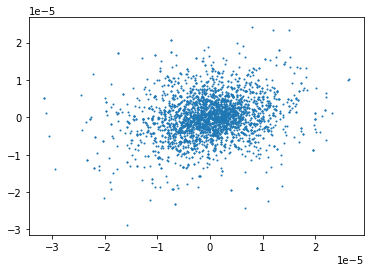

In [ ]:
plt.scatter(sss.iloc[:,2],sss.iloc[:,3],s=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Read Datasets


In [ ]:
# Path of Files
ad_file = path.join(base_dr, 'ad.csv')
ad_image_file = path.join(base_dr, 'ad_image.csv')
ad_title_file = path.join(base_dr, 'ad_title.csv')
click_test_file = path.join(base_dr, 'click_test.csv')
click_train_file = path.join(base_dr, 'click_train.csv')
event_file = path.join(base_dr, 'event.csv')
page_file = path.join(base_dr, 'page.csv')
page_topic_file = path.join(base_dr, 'page_topic.csv')
user_page_view_file = path.join(base_dr, 'user_page_view.csv')

# Load Files into DataFrames
ad_df = pd.read_csv(ad_file)
ad_image_df = pd.read_csv(ad_image_file)
ad_title_df = pd.read_csv(ad_title_file)
click_test_df = pd.read_csv(click_test_file)
click_train_df = pd.read_csv(click_train_file)
event_df = pd.read_csv(event_file)
page_df = pd.read_csv(page_file)
page_topic_df = pd.read_csv(page_topic_file)
user_page_view_df = pd.read_csv(user_page_view_file)

# Utils

<div dir=rtl>
به دلیل محدودیت حافظه ی رم و بزرگ بودن داده، خیلی از مواقع امکان ذخیره سازی داده و انجام عملیات مختلف به روی آن امکان پذیر نیست. یکی از کارهایی که برای رفع این مشکل میتوان انجام داد، کاهش حجم داده است.  در بسیاری از مواقع نوع داده ای که برای ذخیره سازی یک ستون استفاده می شود بزرگتر از حد مورد نیاز است. برای مثال یک ستون داده ای ممکن است از نوع int64 ذخیره شده باشد، اما بیشترین و کمترین مقدار موجود در این ستون، در بازه ی (128,-128] قرار بگیرد. در نتیجه بدون از دست رفتن اطلاعات، می توان این ستون را با نوع داده ای int8 ذخیره سازی کرد. تابع <a href="https://www.kaggle.com/gemartin/load-data-reduce-memory-usage">reduce_mem_usage</a> با استفاده از این مفهوم ساده در مصرف حافظه صرفه جویی میکند. 

</div>

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

<div dir=rtl>
فایل ad_title.csv حاوی کلماتی است که در عنوان هر تبلیغ وجود دارد. بنابراین می توان از representation های آشنایی که برای داده های متنی وجود دارد استفاده کرد.  از این رو تابع زیر برای به دست آوردن representation های bag of word و word frequency و TF-IDF نوشته شده است.
خروجی این تابع یک دیتافریم می باشد که هر سطر آن نشان دهنده یک adId و هر ستون آن نشان دهنده یک کلمه منحصر به فرد از تمامی کلمات موجود در ستون wordId می باشد.
</div>

In [ ]:
def txt_process(data, method='tfidf'):
  adId = data['adId'].unique()
  unq_words = data['wordId'].unique()
  freq_mat = np.zeros((adId.shape[0], unq_words.shape[0]))
  #---------- BAG OF WORD representation ---------#
  if method == 'bow':
    for i in range(adId.shape[0]):
      idx = data[data['adId']==adId[i]]['wordId'].values
      for j in range(idx.shape[0]):
        ind = np.where(unq_words==idx[j])[0][0]
        freq_mat[i, ind] = 1

    adId = pd.DataFrame(adId, columns=['adId'])
    freq_mat = pd.DataFrame(freq_mat)
    freq_mat = pd.concat([adId, freq_mat], axis=1)
    return freq_mat
  #---------- WORD FREQUENCY representation ---------#
  elif method == 'tf':
    for i in range(adId.shape[0]):
      idx = data[data['adId']==adId[i]]['wordId'].values
      for j in range(idx.shape[0]):
        ind = np.where(unq_words==idx[j])[0][0]
        freq_mat[i, ind] += 1

    denominator = np.sum(freq_mat, axis=1).reshape(-1, 1)
    TF = freq_mat/denominator
    adId = pd.DataFrame(adId, columns=['adId'])
    TF = pd.DataFrame(TF)
    TF = pd.concat([adId, TF], axis=1)
    return TF
  #------------- TF-IDF representation -------------#
  elif method == 'tfidf':
    for i in range(adId.shape[0]):
      idx = data[data['adId']==adId[i]]['wordId'].values
      for j in range(idx.shape[0]):
        ind = np.where(unq_words==idx[j])[0][0]
        freq_mat[i, ind] += 1
    denominator = np.sum(freq_mat, axis=1).reshape(-1, 1)
    TF = freq_mat/denominator
    adId = pd.DataFrame(adId, columns=['adId'])
    IDF = freq_mat.shape[0]/np.sum(freq_mat, axis=0).reshape(1, -1)
    IDF = np.repeat(IDF, TF.shape[0], axis=0)
    TFIDF = np.multiply(TF, IDF)
    TFIDF = pd.DataFrame(TFIDF)
    TFIDF = pd.concat([adId, TFIDF], axis=1)
    return TFIDF

# Pipeline Flowchart

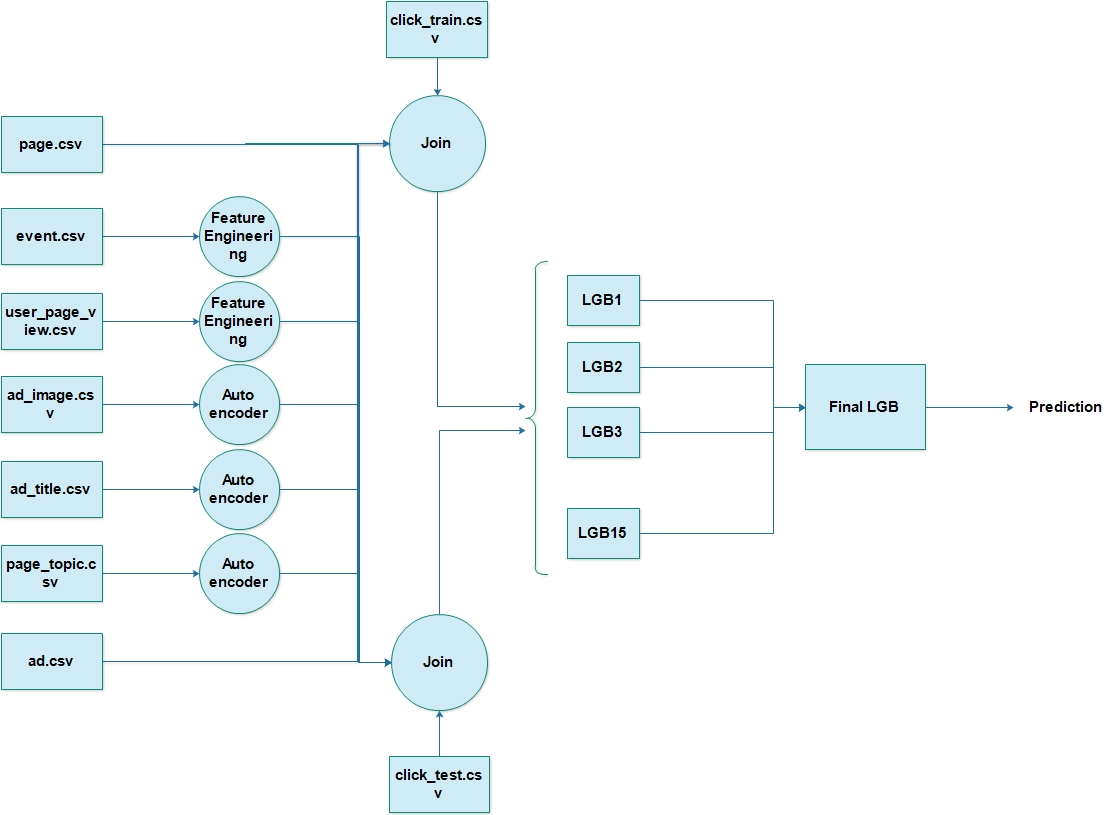

In [ ]:
cv2_imshow(cv2.imread(base_dr+'flow_diagram.jpeg'))

# Feature Engineering

<div dir=rtl>
در این قسمت فیچر های ساخته شده ی جدید و نحوه ی به دست آوردن آنها آورده شده است. برای آشنایی بیشتر در مورد روش های feature engineering مطالعه ی discussion ها و notebook های موجود در <a href="https://www.kaggle.com/">Kaggle</a> بسیار مفید است.<br> برای مثال: <br> <a href="https://www.kaggle.com/luanho/introduction-to-groupby-features">introduction-to-groupby-features</a><br>
<a href="https://www.kaggle.com/rejasupotaro/effective-feature-engineering">effective-feature-engineering</a>

</div>

## event.csv

<div dir=rtl>
فایل event.csv دارای 7 فیچر categorical به همراه ستون زمان (timestamp) است. برای اینکه بتوانیم از ستون زمان به نحو مفیدتری استفاده کنیم، از آن 4 فیچر مفیدتر استخراج میکنیم. در ادامه با در نظرگرفتن مقادیر زمانی مختلف برای 7 فیچر دیگر و اعمال توابع آماری مختلف به رو این رابطه ی زمان_فیچر، فیچر های مفید بیشتری به دست می آوریم.
</div>

In [ ]:
event_df.head(3)

,displayId,timestamp,pageId,widgetId,userId,device,OS,browser
0,4706262,1578429005696,3543873,6262,2688642,0,0,0
1,4706267,1578429007726,6245475,607,2688641,1,3,0
2,4706260,1578429012060,4416499,11458,2688638,0,0,1


### general timestamp features

<div dir=rtl>
4 فیچر به دست آمده از ستون زمان فیچر های  'weekOfMonth', 'dayOfWeek', 'hour' و 'secsOfday' است. 3 فیچر اول از نوع categorical (برخلاف numerical) در نظر گرفته شده است. به این دلیل که نمیتوان معیار فاصله ی مناسبی برای آنها تعریف کرد. برای مثال مقادیر شنبه و دوشنبه با استفاده از معیار l1_norm برابر با 2 است. اما این مقدار فاصله برای روز ها با هفته های مختلف خروجی یکسان تولید میکند. همچنین از لحاظ معنایی هم بزرگتر بودن یک روز از روز دیگر منطقی نیست. اما با در نظر گرفتن نوع numerial برای فیچر 4ام، میتوانیم اطلاعاتی را از ترتیب وقوع مقادیر یک فیچر در یک روز به دست بیاوریم. مثلا اطلاعات بازدید یک صفحه و کلیک کردن یا نکردن ممکن است دارای الگوهایی باشد که میتواند برای آموزش دادن مدل از آن استفاده کرد.
</div>

In [ ]:
event_df.timestamp = event_df.timestamp.transform(lambda x : pd.to_datetime(x, unit='ms'))
event_df['weekOfMonth'] = event_df.timestamp.transform(lambda x : x.week)
event_df['dayOfWeek'] = event_df.timestamp.transform(lambda x : x.dayofweek)
event_df['hour'] = event_df.timestamp.transform(lambda x : x.hour)
event_df['secsOfday'] = event_df.timestamp.transform(lambda x : (x.hour * 3600 + x.minute * 60 + x.second))
event_df.drop('timestamp', axis=1, inplace=True)

event_df.to_csv(base_dr_feats+'new_event_df.csv')

### widgetId

<div dir=rtl>
اگر ما سطر های داده را بر اساس مقادیر یکتای یک فیچر مانند widgetId دسته بندی کنیم به نحوی که در هریک از این دسته سطر ها مقادیر این فیچر یکسان باشد، در این صورت ما می توانیم با مشاهده ی مقادیر بقیه ی فیچ ها برای این دسته از سطر ها، اطلاعات مفیدی به دست بیاوریم. برای مثال در یک دسته از سطر ها میتوانیم تعداد مقادیر یکتایی که فیچر دیگری دارد به عنوان فیچر جدید اضافه کنیم. و یا با دخیل کردن ستون زمان، واریانس زمانی مقادیر مختلف فیچر widgetId را به عنوان فیچر جدید در نظر بگیریم. به طور دقیق تر در یک دسته، که مثلا دارای مقدار x هستند، ستون زمانی آنها میتواند دارای الگوهای خاصی باشد. ما می توانیم این الگو ها را با اعمال توابع مختلف آماری استخراج و در مدل استفاده کنیم. فیچر هایی که با اینگونه دسته بندی به دست می آوریم  شامل فیچر های مقادیر یکتا، که مقادیر یکتای بقیه فیچر ها را می شمارد، و فیچر های آماری که با اعمال <a href="https://docs.scipy.org/doc/scipy/reference/stats.html">توابع آماری</a>  به روی ستون زمان به دست می آیند.
</div>

In [ ]:
widgetId_event_feats = pd.DataFrame()
widgetId_event_feats['widgetId'] = np.sort(event_df.widgetId.unique())
widgetId_event_feats['wi_uniq_dev'] = event_df.groupby('widgetId')['device'].nunique().values
widgetId_event_feats['wi_uniq_os'] = event_df.groupby('widgetId')['OS'].nunique().values
widgetId_event_feats['wi_uniq_bro'] = event_df.groupby('widgetId')['browser'].nunique().values
widgetId_event_feats['wi_uniq_page'] = event_df.groupby('widgetId')['pageId'].nunique().values
widgetId_event_feats['wi_uniq_usr'] = event_df.groupby('widgetId')['userId'].nunique().values

widgetId_event_feats['wi_time_std'] = event_df.groupby('widgetId')['timestamp'].std().values
widgetId_event_feats['wi_time_skew'] = event_df.groupby('widgetId')['timestamp'].skew().values
widgetId_event_feats['wi_time_kurt'] = event_df.groupby('widgetId')['timestamp'].apply(lambda x:stt.kurtosis(x)).values
widgetId_event_feats['wi_time_sem'] = event_df.groupby('widgetId')['timestamp'].apply(lambda x:stt.sem(x)).values
widgetId_event_feats['wi_time_mode'] = event_df.groupby('widgetId')['timestamp'].apply(lambda x:stt.mode(x)[0][0]).values
widgetId_event_feats['wi_time_variation'] = event_df.groupby('widgetId')['timestamp'].apply(lambda x:stt.variation(x)).values
widgetId_event_feats['wi_time_iqr'] = event_df.groupby('widgetId')['timestamp'].apply(lambda x:stt.iqr(x)).values
widgetId_event_feats['wi_time_entropy'] = event_df.groupby('widgetId')['timestamp'].apply(lambda x:stt.entropy(x)).values
widgetId_event_feats['wi_time_mad'] = event_df.groupby('widgetId')['timestamp'].apply(lambda x:stt.median_absolute_deviation(x)).values

widgetId_event_feats['wi_rows'] = event_df.groupby('widgetId').size().values
widgetId_event_feats.to_csv(base_dr_feats+'widgetId_event_feats.csv')

### userID

<div dir=rtl>
فرآیند توضیح داده شده در قسمت قبل برای فیچر userId نیز انجام می شود...
</div>

In [ ]:
userId_event_feats = pd.DataFrame()
userId_event_feats['userId'] = np.sort(event_df.userId.unique())
userId_event_feats['ui_uniq_dev'] = event_df.groupby('userId')['device'].nunique().values
userId_event_feats['ui_uniq_os'] = event_df.groupby('userId')['OS'].nunique().values
userId_event_feats['ui_uniq_bro'] = event_df.groupby('userId')['browser'].nunique().values
userId_event_feats['ui_uniq_page'] = event_df.groupby('userId')['pageId'].nunique().values
userId_event_feats['ui_uniq_wi'] = event_df.groupby('userId')['widgetId'].nunique().values

userId_event_feats['ui_time_std'] = event_df.groupby('userId')['timestamp'].std().values
userId_event_feats['ui_time_skew'] = event_df.groupby('userId')['timestamp'].skew().values
userId_event_feats['ui_time_kurt'] = event_df.groupby('userId')['timestamp'].apply(lambda x:stt.kurtosis(x)).values
userId_event_feats['ui_time_sem'] = event_df.groupby('userId')['timestamp'].apply(lambda x:stt.sem(x)).values
userId_event_feats['ui_time_mode'] = event_df.groupby('userId')['timestamp'].apply(lambda x:stt.mode(x)[0][0]).values
userId_event_feats['ui_time_variation'] = event_df.groupby('userId')['timestamp'].apply(lambda x:stt.variation(x)).values
userId_event_feats['ui_time_iqr'] = event_df.groupby('userId')['timestamp'].apply(lambda x:stt.iqr(x)).values
userId_event_feats['ui_time_entropy'] = event_df.groupby('userId')['timestamp'].apply(lambda x:stt.entropy(x)).values
userId_event_feats['ui_time_mad'] = event_df.groupby('userId')['timestamp'].apply(lambda x:stt.median_absolute_deviation(x)).values

userId_event_feats['ui_rows'] = event_df.groupby('userId').size().values
userId_event_feats.to_csv(base_dr_feats+'userId_event_feats.csv')

### pageId

<div dir=rtl>
...همچنین pageId...
</div>

In [ ]:
pageId_event_feats = pd.DataFrame()
pageId_event_feats['pageId'] = np.sort(event_df.pageId.unique())
pageId_event_feats['pi_uniq_dev'] = event_df.groupby('pageId')['device'].nunique().values
pageId_event_feats['pi_uniq_os'] = event_df.groupby('pageId')['OS'].nunique().values
pageId_event_feats['pi_uniq_bro'] = event_df.groupby('pageId')['browser'].nunique().values
pageId_event_feats['pi_uniq_usr'] = event_df.groupby('pageId')['userId'].nunique().values
pageId_event_feats['pi_uniq_wi'] = event_df.groupby('pageId')['widgetId'].nunique().values

pageId_event_feats['pi_time_std'] = event_df.groupby('pageId')['timestamp'].std().values
pageId_event_feats['pi_time_skew'] = event_df.groupby('pageId')['timestamp'].skew().values
pageId_event_feats['pi_time_kurt'] = event_df.groupby('pageId')['timestamp'].apply(lambda x:stt.kurtosis(x)).values
pageId_event_feats['pi_time_sem'] = event_df.groupby('pageId')['timestamp'].apply(lambda x:stt.sem(x)).values
pageId_event_feats['pi_time_mode'] = event_df.groupby('pageId')['timestamp'].apply(lambda x:stt.mode(x)[0][0]).values
pageId_event_feats['pi_time_variation'] = event_df.groupby('pageId')['timestamp'].apply(lambda x:stt.variation(x)).values
pageId_event_feats['pi_time_iqr'] = event_df.groupby('pageId')['timestamp'].apply(lambda x:stt.iqr(x)).values
pageId_event_feats['pi_time_entropy'] = event_df.groupby('pageId')['timestamp'].apply(lambda x:stt.entropy(x)).values
pageId_event_feats['pi_time_mad'] = event_df.groupby('pageId')['timestamp'].apply(lambda x:stt.median_absolute_deviation(x)).values

pageId_event_feats['pi_rows'] = event_df.groupby('pageId').size().values
pageId_event_feats.to_csv(base_dr_feats+'pageId_event_feats.csv')

### browser

<div dir=rtl>
...و browser.
</div>

In [ ]:
browser_event_feats = pd.DataFrame()
browser_event_feats['browser'] = np.sort(event_df.browser.unique())
browser_event_feats['br_uniq_dev'] = event_df.groupby('browser')['device'].nunique().values
browser_event_feats['br_uniq_os'] = event_df.groupby('browser')['OS'].nunique().values
browser_event_feats['br_uniq_page'] = event_df.groupby('browser')['pageId'].nunique().values
browser_event_feats['br_uniq_usr'] = event_df.groupby('browser')['userId'].nunique().values
browser_event_feats['br_uniq_wi'] = event_df.groupby('browser')['widgetId'].nunique().values

browser_event_feats['br_time_std'] = event_df.groupby('browser')['timestamp'].std().values
browser_event_feats['br_time_skew'] = event_df.groupby('browser')['timestamp'].skew().values
browser_event_feats['br_time_kurt'] = event_df.groupby('browser')['timestamp'].apply(lambda x:stt.kurtosis(x)).values
browser_event_feats['br_time_sem'] = event_df.groupby('browser')['timestamp'].apply(lambda x:stt.sem(x)).values
browser_event_feats['br_time_mode'] = event_df.groupby('browser')['timestamp'].apply(lambda x:stt.mode(x)[0][0]).values
browser_event_feats['br_time_variation'] = event_df.groupby('browser')['timestamp'].apply(lambda x:stt.variation(x)).values
browser_event_feats['br_time_iqr'] = event_df.groupby('browser')['timestamp'].apply(lambda x:stt.iqr(x)).values
browser_event_feats['br_time_entropy'] = event_df.groupby('browser')['timestamp'].apply(lambda x:stt.entropy(x)).values
browser_event_feats['br_time_mad'] = event_df.groupby('browser')['timestamp'].apply(lambda x:stt.median_absolute_deviation(x)).values

browser_event_feats['br_rows'] = event_df.groupby('browser').size().values
browser_event_feats.to_csv(base_dr_feats+'browser_event_feats.csv')

### other categoricals?

<div dir=rtl>
پروسه ی فوق به روی بقیه ی فیچر های categorical مثل OS و device به دلیل اینکه این فیچر ها مقادیر یکتای کمی داشتند انجام نشد.
</div>

## user_page_view.csv

<div dir=rtl>
فایل user_page_view.csv شامل اطلاعات ثبت شده ی بازدید از صفحه است که دارای ستون های مشابه فایل event.csv می باشد. این بدین معنی است که ما میتوانیم پروسه ی قبلی را برای این فایل نیز انجام دهیم. با این تفاوت که فیچر های به دست آمده در این مرحله شامل اطلاعات مربوط به بازدید از صفحات است. به این دلیل که  از دید ما این اطلاعات بازدید بیشتر به کاربران (userId) و صفحات (pageId) مرتبط است، فیچر های جدید با استفاده از این 2 فیچر به دست می آیند.
</div>

In [ ]:
user_page_view_df.head()

,userId,pageId,timestamp
0,821961,8116,1579599211445
1,15321,9533442,1579599211443
2,1125090,9410379,1579599211440
3,407101,8616213,1579599211429
4,781615,9543366,1579599211429


### userId

In [ ]:
page_view_userId_feats = pd.DataFrame()
page_view_userId_feats['userId'] = np.sort(user_page_view_df.userId.unique())
page_view_userId_feats['ui_pv_uniq_page'] = user_page_view_df.groupby('userId')['pageId'].nunique().values
page_view_userId_feats['ui_pv_all_page'] = user_page_view_df.groupby('userId').size().values

page_view_userId_feats['ui_pv_time_std'] = user_page_view_df.groupby('userId')['timestamp'].std().values
page_view_userId_feats['ui_pv_time_skew'] = user_page_view_df.groupby('userId')['timestamp'].skew().values
page_view_userId_feats['ui_pv_time_kurt'] = user_page_view_df.groupby('userId')['timestamp'].apply(lambda x:stt.kurtosis(x)).values
page_view_userId_feats['ui_pv_time_sem'] = user_page_view_df.groupby('userId')['timestamp'].apply(lambda x:stt.sem(x)).values
page_view_userId_feats['ui_pv_time_mode'] = user_page_view_df.groupby('userId')['timestamp'].apply(lambda x:stt.mode(x)[0][0]).values
page_view_userId_feats['ui_pv_time_variation'] = user_page_view_df.groupby('userId')['timestamp'].apply(lambda x:stt.variation(x)).values
page_view_userId_feats['ui_pv_time_iqr'] = user_page_view_df.groupby('userId')['timestamp'].apply(lambda x:stt.iqr(x)).values
page_view_userId_feats['ui_pv_time_entropy'] = user_page_view_df.groupby('userId')['timestamp'].apply(lambda x:stt.entropy(x)).values
page_view_userId_feats['ui_pv_time_mad'] = user_page_view_df.groupby('userId')['timestamp'].apply(lambda x:stt.median_absolute_deviation(x)).values
page_view_userId_feats['ui_pv_time_interv'] = user_page_view_df.groupby('userId')['timestamp'].apply(lambda x:(x.max()-x.min())).values

aaa=user_page_view_df.groupby('userId')['pageId'].value_counts()
page_view_userId_feats['ui_pv_most_frq_page'] = aaa.groupby('userId').max().values

page_view_userId_feats.to_csv(base_dr_feats+'page_view_userId_feats.csv')

### pageId

In [ ]:
page_view_pageId_feats = pd.DataFrame()
page_view_pageId_feats['pageId'] = np.sort(user_page_view_df.pageId.unique())
page_view_pageId_feats['pi_pv_uniq_page'] = user_page_view_df.groupby('pageId')['userId'].nunique().values
page_view_pageId_feats['pi_pv_all_page'] = user_page_view_df.groupby('pageId').size().values


page_view_pageId_feats['pi_pv_time_std'] = user_page_view_df.groupby('pageId')['timestamp'].std().values
page_view_pageId_feats['pi_pv_time_skew'] = user_page_view_df.groupby('pageId')['timestamp'].skew().values
page_view_pageId_feats['pi_pv_time_kurt'] = user_page_view_df.groupby('pageId')['timestamp'].apply(lambda x:stt.kurtosis(x)).values
page_view_pageId_feats['pi_pv_time_sem'] = user_page_view_df.groupby('pageId')['timestamp'].apply(lambda x:stt.sem(x)).values
page_view_pageId_feats['pi_pv_time_mode'] = user_page_view_df.groupby('pageId')['timestamp'].apply(lambda x:stt.mode(x)[0][0]).values
page_view_pageId_feats['pi_pv_time_variation'] = user_page_view_df.groupby('pageId')['timestamp'].apply(lambda x:stt.variation(x)).values
page_view_pageId_feats['pi_pv_time_iqr'] = user_page_view_df.groupby('pageId')['timestamp'].apply(lambda x:stt.iqr(x)).values
page_view_pageId_feats['pi_pv_time_entropy'] = user_page_view_df.groupby('pageId')['timestamp'].apply(lambda x:stt.entropy(x)).values
page_view_pageId_feats['pi_pv_time_mad'] = user_page_view_df.groupby('pageId')['timestamp'].apply(lambda x:stt.median_absolute_deviation(x)).values
page_view_pageId_feats['pi_pv_time_interv'] = user_page_view_df.groupby('pageId')['timestamp'].apply(lambda x:(x.max()-x.min())).values

aaa=user_page_view_df.groupby('pageId')['userId'].value_counts()
page_view_pageId_feats['pi_pv_most_frq_page'] = aaa.groupby('pageId').max().values

page_view_pageId_feats.to_csv(base_dr_feats+'page_view_pageId_feats.csv')

# Features that obtain from Auto-Encoder

### autoencoder learning rates

<div dir=rtl>
ما برای استراتژی مقداردهی Learning rate از ایده ی  <a href="https://arxiv.org/abs/1708.07120">SuperConvergence</a> و با تابع زمانی خاصی که برای این مساله تعریف کردیم، استفاده کردیم. به طور خلاصه ایئه به این صورت است که با استفاده از مقادیر LR بزرگ به همراه مقادیر کوچکتر، میتوانیم مدل ها را با سرعت بیشتری آموزش بدیم و مدل سیرعتر همگرا شود.
</div>

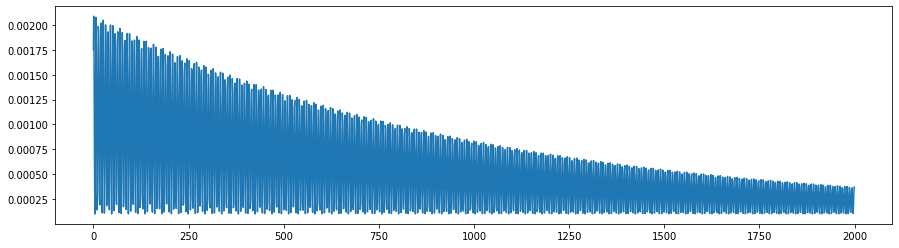

In [ ]:
f = lambda iter: 0.0001 + 0.002 * (0.999 ** iter*1*(np.sin((iter/2)-2))**2)
aa= [f(i) for i in range(10000)]
plt.figure(figsize=(15,4))
plt.plot(aa[:2000])

### Page Topics

<div dir=rtl>
ماتریس تاپیک ها یک ماتریس خلوت می باشد و پس از متصل کردن آن به ماتریس click_train مقادیر از دست رفته(missing values) زیادی خواهیم داشت (ما مقدار این درایه ها را صفر قرار داده ایم)، بنابراین تصمیم گرفتیم این ماتریس را فشرده تر کرده و ویژگی هایی را از این ماتریس به دست آوریم که مفید باشند. برای این منظور تصمیم به استفاده از autoencoder ها به دلیل توانایی بالا در استخراج ویژگی های مفید و غیرخطی بودن آن گرفتیم. در این قسمت از Stacked Denoising Autoencoder استفاده کرده ایم و علت آن نتایج مناسب این مدل در استخراج ویژگی نسبت به سایر autoencoder ها بوده که در پایینتر نشان داده شده است.
برای آموزش مدل از ویژگی های آن تاپیک هایی استفاده کرده ایم که مقدار page Id آن ها در داده های آموزشی و آزمایشی وجود داشته است. 

</div>

Matrice of topics is very sparse and after joining it with 'click_train' we have many missing values, so we decide to compact this matrice and reduce its dimension to extract useful features. for this reason we use Auto-encoders. In this step we use Stacked Denoising Auto-encoder. We train it on topics of that 'page Id' that exist in training and test dataset.
Codes and Structure of network show below. So we map our page topics to 8 dimension.


In [ ]:
# learning rate Schedul
def lr_schedule(epoch):
  if epoch < 10:
    return 0.005
  elif epoch < 20:
    return 0.001
  else:
    return 0.0001
lrs = tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)

def layerwise_training(xtrain, hidsize, counter, lrs):
  inp_shape = xtrain.shape[1]
  print('AE', counter, ':', inp_shape, '-->', hidsize)
  inp = tf.keras.layers.Input(shape=[inp_shape], name='inp_enc'+str(counter))
  de_inp = tf.keras.layers.Dropout(0.2, name='de_enc'+str(counter))(inp)
  if counter==4:
    hid = tf.keras.layers.Dense(hidsize, kernel_initializer='uniform', name='latent'+str(counter))(de_inp) #
  else:
    hid = tf.keras.layers.Dense(hidsize, activation='tanh', kernel_initializer='uniform', name='latent'+str(counter))(de_inp)

  latent_inputs = tf.keras.layers.Input(shape=[hidsize], name='inp_dec'+str(counter))
  de_hid = tf.keras.layers.Dropout(0.2, name='de_dec'+str(counter))(latent_inputs)
  if counter==0:
    out = tf.keras.layers.Dense(inp_shape, kernel_initializer='uniform', name='out'+str(counter))(de_hid) # 
  else:
    out = tf.keras.layers.Dense(inp_shape, activation='tanh', kernel_initializer='uniform', name='out'+str(counter))(de_hid)
  
  encoder = tf.keras.models.Model(inp, hid, name='encoder'+str(counter))
  decoder = tf.keras.models.Model(latent_inputs, out, name='decoder'+str(counter))
  AE = tf.keras.models.Model(inp, decoder(encoder(inp)), name='AE'+str(counter))
  AE.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mse')
  history = AE.fit(xtrain, xtrain, epochs=30,
                      batch_size=32*8,
                      callbacks=[lrs])
  return (encoder, decoder)

# layerwise training 
dims = [20, 20, 20, 8]
modelss = []
train_inp = np.copy(data)
for i in range(len(dims)):
  modelss.append(layerwise_training(train_inp, dims[i], i, lrs))
  train_inp = modelss[-1][0].predict(train_inp)


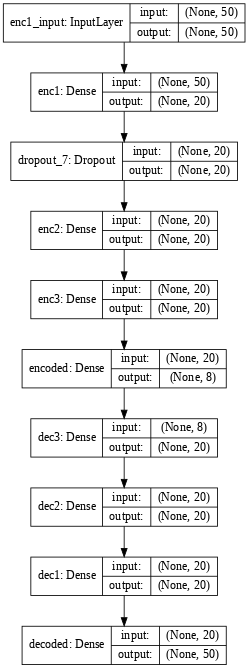

In [ ]:
import tensorflow as tf
def lr_schedule(epoch):
  if epoch < 10:
    return 0.001
  elif epoch < 20:
    return 0.0001
  elif epoch < 30:
    return 0.00001
  else:
    return 0.00005
lrs = tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)
kr=tf.keras.regularizers.l2(0.0001)

inp = tf.keras.layers.Input(shape=(data.shape[1],), name='inp_enc')
hid = tf.keras.layers.Dropout(0.2, name='de_enc')(inp)
hid = tf.keras.layers.Dense(dims[0], activation='tanh', name='enc1')(hid)
hid = tf.keras.layers.Dense(dims[1], activation='tanh', name='enc2')(hid)
hid = tf.keras.layers.Dense(dims[2], activation='tanh', name='enc3')(hid)
encode = tf.keras.layers.Dense(dims[3],name='latent')(hid)

latent_inputs = tf.keras.layers.Input(shape=(dims[3],), name='inp_dec')
hid = tf.keras.layers.Dense(dims[2], activation='tanh', name='dec3')(latent_inputs)
hid = tf.keras.layers.Dense(dims[1], activation='tanh', name='dec2')(hid)
hid = tf.keras.layers.Dense(dims[0], activation='tanh', name='dec1')(hid)
out = tf.keras.layers.Dense(data.shape[1], name='out_dec')(hid)

encoder = tf.keras.models.Model(inp, encode, name='encoder')
decoder = tf.keras.models.Model(latent_inputs, out, name='decoder')
AE = tf.keras.models.Model(inp, decoder(encoder(inp)), name='AE')
plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)
# initialize learned weights
for i in range(len(dims)):
  encoder.layers[i+2].set_weights(modelss[i][0].get_weights())
counter = 0
for i in range(len(dims)-1, -1, -1):
  decoder.layers[counter+1].set_weights(modelss[i][1].get_weights())
  counter+=1

# compile model and train it
AE.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss='mse')
history = AE.fit(data, data, epochs=15,
                  batch_size=2*8,
                  initial_epoch=0,
                  callbacks=[lrs])

topic_ae_feats = encoder.predict(data)
topic_ae_feats = pd.DataFrame(topic_ae_feats)
topic_ae_feats = topic_ae_feats.rename({0: 'adId'}, axis=1)
for i in range(1, topic_ae_feats.shape[1]):
  topic_ae_feats = topic_ae_feats.rename({i: 'topic_'+str(i)}, axis=1)
topic_ae_feats.to_csv(base_dr+'topic_ae_feats8D.csv', index=False)

نمایش داده نگاشت شده توسط مدل در دوره اول و آخر

**for show the effectiveness of autoencoder we show mapped data in 2 dimension in first and last epoch.**

before mapping



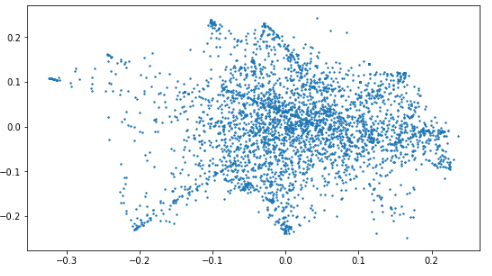


after mapping



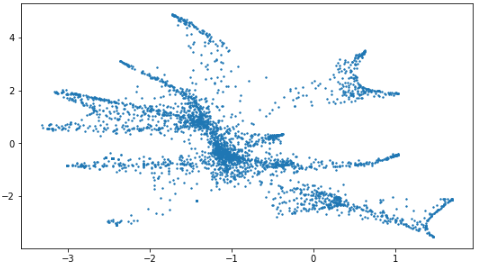

In [ ]:
print('before mapping\n')
cv2_imshow(cv2.imread(base_dr+'sources/Topics_before_mapping.png'))
plt.show()
print('\nafter mapping\n')
cv2_imshow(cv2.imread(base_dr+'sources/topics_after_mapping.png'))


### Advertisement Titles

در ابتدا از روی داده ad_title.csv با استفاده از تابع txt_precess() که در قبلتر توضیح داده شد مدل TF-IDF را برای کلمات adId ها ساختیم. این ماتریس نیز ماتریسی خلوت می باشد زیرا تعداد کلمات منحصر به فرد موجود 2108 کلمه بوده و تعداد کلمات هر تبلیغ عددی بسیار کوچکتر از آن است.
بنابراین در این قسمت نیز تصمیم به استفاده از auto-encoder گرفتیم.

First we build TF-IDF (Term Frequency-Inverse Document Frequency) model for title words of "adId"s, so for each unique "adId" we have 2108 column (we have 2108 unique word in all titles) and each entry "ij" show value of TF-IDF model for i-th "adId" and j-th unique title word.
this matrice is also a sparse matrice and has missing values after joinig it with "click_train". so we apply Auto-encoder on it to get useful features.
Structure of network show below. so we map our advertisement titles to 8 dimension.

In [ ]:
kc = tf.keras.constraints.UnitNorm(axis=0)
from tensorflow.keras.regularizers import SparseActivityRegularizer
def get_ae():
    acti='tanh'
    acti2='linear'
    
    ki=tf.keras.initializers.VarianceScaling(scale=.1, mode='fan_in', distribution='normal', seed=None) #scale=2 -> he_normal
    kr=tf.keras.regularizers.l2(0.5)
    inp = tf.keras.layers.Input(shape=(2108,))
    gn=0.01
    e = tf.keras.layers.GaussianNoise(gn)(inp)
    regularizer = SparseActivityRegularizer(0.5, 10)
    for i in range(10):
        if i==9:
            e = tf.keras.layers.Dense(2**(10-i),activation=acti2,kernel_initializer=ki,
                            kernel_constraint=kc,
                            activity_regularizer=kl_divergence_regularizer
                           )(e)
        else:
            e = tf.keras.layers.Dense(2**(10-i),activation=acti,kernel_initializer=ki
                                ,kernel_constraint=kc
                               )(e)
    for i in range(9):
        if i==0:
            d = tf.keras.layers.Dense(2**(i+2), activation=acti,kernel_initializer=ki
                                      ,kernel_constraint=kc
                                     )(e)
        else:
            d = tf.keras.layers.Dense(2**(i+2), activation=acti,kernel_initializer=ki
                                      ,kernel_constraint=kc
                                     )(d)
            
    d = tf.keras.layers.Dense(2108, activation=acti,kernel_initializer=ki
                                      ,kernel_constraint=kc
                                     )(d)
    enc = tf.keras.Model(inp,e)
    ae = tf.keras.Model(inp,d)
    return enc, ae

(enc, ae) = get_ae()
plot_model(ae, show_shapes=True, show_layer_names=True, dpi=60)

**The effectiveness of autoencoder shown below.**

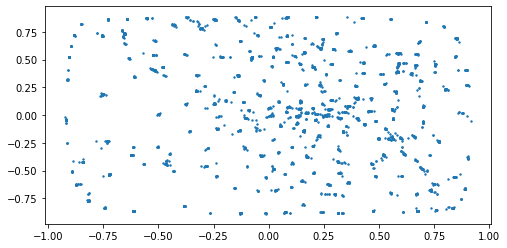

In [ ]:
title_2d = pd.read_csv(base_dr+'title_ae_feats.csv')
plt.figure(figsize=(8,4))
plt.scatter(title_2d.iloc[:, 2], title_2d.iloc[:, 3], s=2)
plt.show()

### Advertisement Images

به دلیل کمبود منابع محاسباتی، مخصوصا RAM، امکان متصل کردن داده ad_image.csv و click_train.csv وجود نداشت. بنابراین تصمیم گرفته شد، ابتدا به صورت جدا ابعاد ویژگی های موجود از عکس ها را کم کرده و سپس از آن استفاده کنیم. مجددا به همان دلیل توانایی auto-encoder ها در استخراج ویژگی های غیرخطی در اینجا نیز از آن استفاده شد.

because limitation of source, specially RAM, we can't join images to "click_train" matrix, so we decide to reduce their dimension. the structure of considered autoencoder network is

In [ ]:
kc = tf.keras.constraints.UnitNorm(axis=0)
lss=[int(512*(0.75**i)) for i in range(13)]
def get_ae_im():
    acti='tanh'
    acti2='linear'
    ki=tf.keras.initializers.VarianceScaling(scale=.1, mode='fan_in', distribution='normal', seed=None) #scale=2 -> he_normal
    inp = tf.keras.layers.Input(shape=(512,))
    gn=0.05
    e = tf.keras.layers.GaussianNoise(gn)(inp)
    for i in range(13):
        if i==12:
            e = tf.keras.layers.Dense(lss[i],activation=acti,kernel_initializer=ki,
                            kernel_constraint=kc)(e)
        else:
            e = tf.keras.layers.Dense(lss[i],activation=acti,kernel_initializer=ki
                                ,kernel_constraint=kc)(e)
    for i in range(1,13):
        if i==1:
            d = tf.keras.layers.Dense(lss[12-i], activation=acti,kernel_initializer=ki
                                      ,kernel_constraint=kc)(e)           
        else:
            d = tf.keras.layers.Dense(lss[12-i], activation=acti,kernel_initializer=ki
                                      ,kernel_constraint=kc)(d)

    d = tf.keras.layers.Dense(512, activation=acti2,kernel_initializer=ki
                                      ,kernel_constraint=kc)(d)
    enc = tf.keras.Model(inp,e)
    dec = tf.keras.Model(inp,d)
    return enc, dec

**Autoencoder learning rate:**
we use the idea of SuperConvergence presented in https://arxiv.org/abs/1708.07120. but we form our own customized function for our problem.



In [ ]:
f = lambda iter: 0.0001 + 0.002 * (0.999 ** iter*1*(np.sin((iter/2)-2))**2)
aa= [f(i) for i in range(10000)]
plt.figure(figsize=(15,4))
plt.plot(aa[2000:])

**result of autoencoder in 2 dimension**

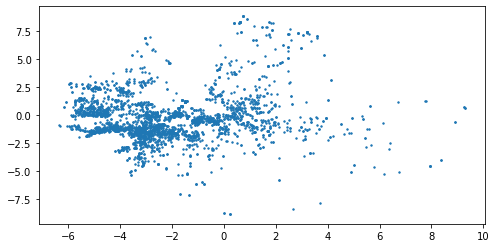

In [ ]:
img_2d = pd.read_csv(base_dr+'img_ae_feats.csv')
plt.figure(figsize=(8,4))
plt.scatter(img_2d.iloc[:, 1], img_2d.iloc[:, 2], s=2)
plt.show()

# Join all features

In [ ]:
new_event_df = reduce_mem_usage(pd.read_csv(base_dr_feats+'new_event_df.csv', index_col=0))

widgetId_event_feats = reduce_mem_usage(pd.read_csv(base_dr_feats+'widgetId_event_feats.csv', index_col=0))
userId_event_feats = reduce_mem_usage(pd.read_csv(base_dr_feats+'userId_event_feats.csv', index_col=0))
pageId_event_feats = reduce_mem_usage(pd.read_csv(base_dr_feats+'pageId_event_feats.csv', index_col=0))
browser_event_feats = reduce_mem_usage(pd.read_csv(base_dr_feats+'browser_event_feats.csv', index_col=0))
page_view_userId_feats = reduce_mem_usage(pd.read_csv(base_dr_feats+'page_view_userId_feats.csv', index_col=0))
page_view_pageId_feats = reduce_mem_usage(pd.read_csv(base_dr_feats+'page_view_pageId_feats.csv', index_col=0))

title_ae_feats = pd.read_csv(base_dr+'title_ae_feats_8D.csv', index_col=0)
image_ae_feats =  pd.read_csv(base_dr+'image_ae_feats_16D.csv', index_col=0)
topic_ae_feats = pd.read_csv(base_dr+'8D_topic.csv', index_col=0)
topic_ae_feats = topic_ae_feats.reset_index()

gc.collect()

Memory usage of dataframe is 99.16 MB
Memory usage after optimization is: 33.05 MB
Decreased by 66.7%
Memory usage of dataframe is 0.16 MB
Memory usage after optimization is: 0.06 MB
Decreased by 59.6%
Memory usage of dataframe is 109.52 MB
Memory usage after optimization is: 41.07 MB
Decreased by 62.5%
Memory usage of dataframe is 24.44 MB
Memory usage after optimization is: 9.34 MB
Decreased by 61.8%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.00 MB
Decreased by 58.1%
Memory usage of dataframe is 90.91 MB
Memory usage after optimization is: 42.43 MB
Decreased by 53.3%
Memory usage of dataframe is 144.83 MB
Memory usage after optimization is: 70.00 MB
Decreased by 51.7%


0

In [ ]:
train_feats = click_train_df.join(ad_df.set_index('adId'), on='adId')
test_feats = click_test_df.join(ad_df.set_index('adId'), on='adId')

train_feats = train_feats.join(new_event_df.set_index('displayId'), on='displayId')
test_feats = test_feats.join(new_event_df.set_index('displayId'), on='displayId')

train_feats = train_feats.join(page_df.set_index('pageId'), on='pageId')
test_feats = test_feats.join(page_df.set_index('pageId'), on='pageId')

train_feats = train_feats.join(widgetId_event_feats.set_index('widgetId'), on='widgetId')
test_feats = test_feats.join(widgetId_event_feats.set_index('widgetId'), on='widgetId')

train_feats = train_feats.join(userId_event_feats.set_index('userId'), on='userId')
test_feats = test_feats.join(userId_event_feats.set_index('userId'), on='userId')

train_feats = train_feats.join(pageId_event_feats.set_index('pageId'), on='pageId')
test_feats = test_feats.join(pageId_event_feats.set_index('pageId'), on='pageId')

train_feats = train_feats.join(browser_event_feats.set_index('browser'), on='browser')
test_feats = test_feats.join(browser_event_feats.set_index('browser'), on='browser')

train_feats = train_feats.join(page_view_userId_feats.set_index('userId'), on='userId')
test_feats = test_feats.join(page_view_userId_feats.set_index('userId'), on='userId')

train_feats = train_feats.join(page_view_pageId_feats.set_index('pageId'), on='pageId')
test_feats = test_feats.join(page_view_pageId_feats.set_index('pageId'), on='pageId')

train_feats = train_feats.join(title_ae_feats.set_index('adId'), on='adId')
test_feats = test_feats.join(title_ae_feats.set_index('adId'), on='adId')

train_feats = train_feats.join(image_ae_feats.set_index('adId'), on='adId')
test_feats = test_feats.join(image_ae_feats.set_index('adId'), on='adId')

train_feats = train_feats.join(topic_ae_feats.set_index('pageId'), on='pageId')
test_feats = test_feats.join(topic_ae_feats.set_index('pageId'), on='pageId')

gc.collect()

0

**label encoding for categorical features**

In [ ]:
# import gc
all_cols = list(train_feats.columns)
del all_cols[2]

X = train_feats.drop(['clicked'], axis=1)
y = train_feats['clicked'].values
X_test = test_feats

cat_cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,14,15]
le_cols = []
for col_i in cat_cols:
  le = LabelEncoder()
  le.fit(np.hstack([X[all_cols[col_i]].values, X_test[all_cols[col_i]]]))
  X[all_cols[col_i]] = le.transform(X[all_cols[col_i]]).astype(np.int32)
  X_test[all_cols[col_i]] = le.transform( X_test[all_cols[col_i]]).astype(np.int32)
  le_cols.append(le)

gc.collect()

22

#Some EDAs and insights on features

<div dir=rtl>
یکی از نکات مهم در حل یک مساله، استفاده از ابزارهای مختلف برای visualization  داده است. رسم اشکال و نمودار های مختلف درک بهتری از داده ارایه و مسیر حل مساله را روشن تر میکند. همچنین در بعضی مواقع ممکن است ایده بسیار خاص و کلیدی برای حل مساله در اختیار ما بگذارد. برای مساله ی فعلی، ما با استفاده از رسم نمودار به ایده ی کلیدی ای دست نیافتیم ولی به بعضی حالات خاص برخوردیم که در ادامه توضیح داده می شود. 
</div>

## displayId

<div dir=rtl>
با رسم نمودار هیستوگرام فیچر displayId برای داده آموزشی با برچسب 0 و 1 و داده آزمایشی، میتوانیم مشاهده کنیم که داده هایی آموزشی با برچسب 1 به صورت کاملا یکنواخت تبدیل شده است. که به ما می گوید تعدادی از داده های آموزشی با برچسب 1 حذف شده اند. به طور دقیق تر به نظر میرسد به ازای هر displayId حدود 5000 نمونه نگه داشته شده و بقیه حذف شده اند. البته ما از این یافته نتوانستیم به طور موثری در مدل خود استفاده کنیم. ولی شاید بتوان با بررسی بیشتر از این نکته استفاده ی بهینه کرد.
</div>

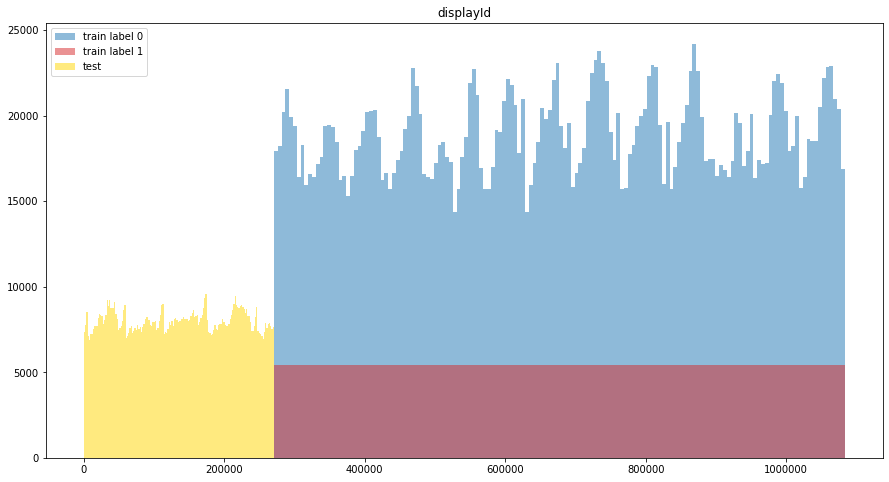

In [ ]:
ii=0
plt.figure(figsize=(15,8))
plt.hist(X.iloc[y==0,ii],bins=150, alpha=.5, color='tab:blue')
plt.hist(X.iloc[y==1,ii],bins=150,  alpha=.5, color='tab:red')
plt.hist(X_test.iloc[:,ii], bins=150,  alpha=.5, color='gold')
plt.title(X.columns[ii])
plt.legend(['train label 0','train label 1','test'])
plt.show()

## for some features, some values only present in test data

<div dir=rtl>
برای بعضی از فیچر ها اگر نمودار توزیع آنها را رسم کنیم، مشاهده میکنیم که بعضی از مقادیر برای این فیچر فقط در داده test وجود دارد و این مقادیر در train غایب هستند. که ممکن است این حالت به دلیل حذف نمونه هایی که در هیستوگرام قبلی مشاهده کردیم باشد. به همین دلیل ما این مقادیر را در داده ی test با NaN عوض کردیم. با فرض اینکه در قسمت قبل فقط از نمونه های با برچسب 1 حذف شده باشد، ممکن است نمونه هایی که مقادیر آنها در train وجود ندارد دارای برچسب 1 باشند (ایده تست نشده)
</div>

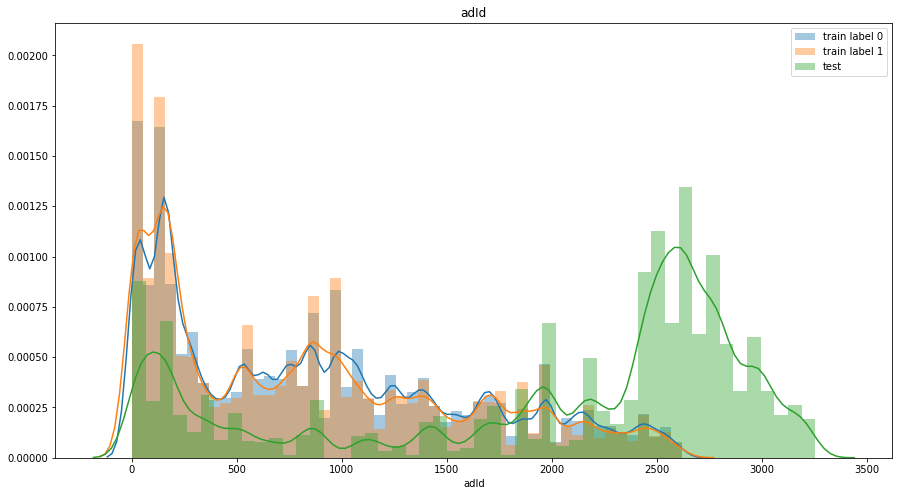

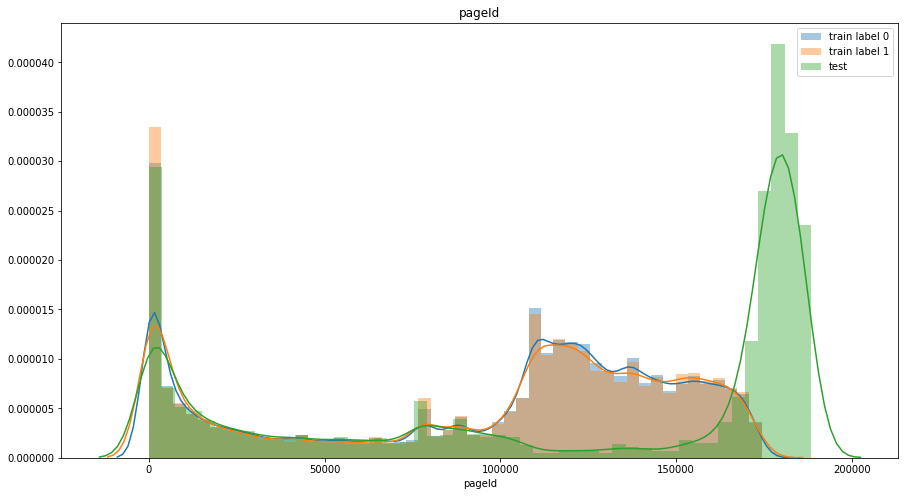

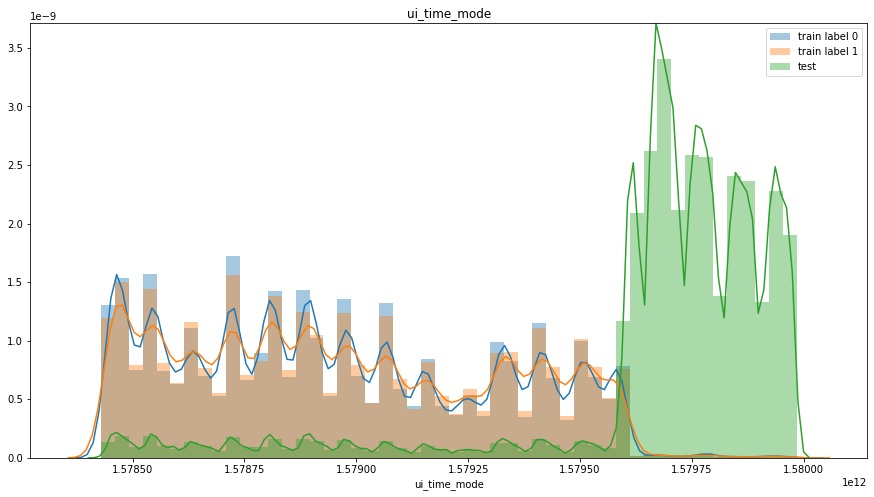

In [ ]:
for ii in [1,4,40]:
  plt.figure(figsize=(15,8))

  sns.distplot(X.iloc[y==0,ii])
  sns.distplot(X.iloc[y==1,ii])
  sns.distplot(X_test.iloc[:,ii])

  plt.title(X.columns[ii])
  plt.legend(['train label 0','train label 1','test'])
  plt.show()

## distribution on userId

<div dir=rtl>
 در نمودار توزیع userId  میتوانیم ناهنجاری واضحی را مشاهده کنیم. به طور مشخص UserId هایی که در test وجود دارند به طور قابل توجهی در train کمتر هستند. که این ناهنجاری نیز ممکن است در اثر حدف نمونه ها بر اساس displayId صورت گرفته باشد. برای مقابله با این مشکل ما وزن بیشتری برای نمونه هایی از train که userId آنها در test وجود دارند در نظر گرفتیم.
</div>

from plotting userId distribution we can see that for userIds in test data, there are an anomaly in distribution of userId in train data. i.e. some of rows that has the yserId present in test data are removed from train data. to overcome this issue, we set a weight to train data rows which their userId is present in test data. to put in other words. we tried to make userId distribution in train data more uniform.

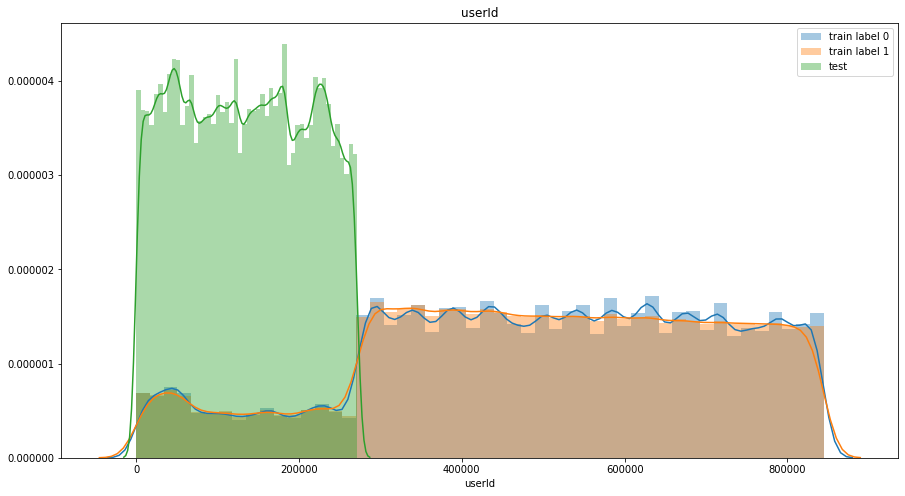

In [ ]:
ii=6
plt.figure(figsize=(15,8))

sns.distplot(X.iloc[y==0,ii])
sns.distplot(X.iloc[y==1,ii])
sns.distplot(X_test.iloc[:,ii])

plt.title(X.columns[ii])
plt.legend(['train label 0','train label 1','test'])
plt.show()

## Adjusments according EDA

<div dir=rtl>
 در این قسمت تغییراتی که با تحلیل داده تعیین شد اعمال می شود. 3 خط اول وزن دهی بیشتر به نمونه هایی از train که userId آنها در test وجود دارد. و 4 خط بعدی NaN کردن مقادیری از test که در train نیست.
</div>

In [ ]:
ww=np.ones(X.shape[0])
ww[X.userId.isin(intu)] = 5          
wwt=5*np.ones(X_test.shape[0])

X_test['adId'][X_test.adId > np.max(X.adId)] = np.nan
X_test['pageId'][X_test.pageId > np.max(X.pageId)] = np.nan
X_test['ui_time_mode'][X_test.ui_time_mode > np.max(X.ui_time_mode)] = np.nan
X_test['pi_time_mode'][X_test.pi_time_mode > np.max(X.pi_time_mode)] = np.nan

# Model

<div dir=rtl>
ما برای حل این مساله دو روش کلی را مد نظر داشتیم. یکی روش های Deep Learning و دیگری روش های Gradient Boosting.<br>
به دلیل بزرگ بودن داده، ابتدا روش های DL را بررسی کردیم. پس از آزمایش ساختار های مختلف، به نتایج خوبی نرسیدیم و مهمتر اینکه خروجی شبکه ها پایدار نبود و نمیشد عملکردش را به درستی ارزیابی کرد. در نتیجه روش های Gradient Boosting را برای ادامه ی کار انتخاب کردیم.<br>
از بین  این روش ها، LightGBM به دلیل داشتن سرعت بالا و نیز قابلیت کار با فیچر های categorical، انتخاب شد.<br>
برای مقایسه و انتخاب ابزار یادگیری، می توان به منابع زیر اشاره کرد:<br>
<a href="https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76100">Gradiant Boosting vs. Neural Net</a><br>
<a href="https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89909">Good summary of XGBoost vs CatBoost vs LightGBM</a><br><br>
پس از به دست آوردن تمام فیچر های جدید، ما ابتدا از روش KFold معمولی برای اعتبارسنجی(validation) روش استفاده کردیم. با آزمایش ترکیب های مختلف فیچر ها، متوجه شدیم که فیچر displayId همیشه دارای feature importance صفر در lightgbm بود. بنابراین به دلیل اینکه این فیچر از نظر ما مهم بود(چون ارتباط کلیک کردن بین این فیچر و adId تعریف می شود)، در پی راهی برای استفاده از این فیچر شدیم. با بررسی راهکارهای مختلف متوجه شدیم که اگر از روش <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html">

</div>

for training the model, first we used standard kfold with k=10. after testing various features and parameters, we observe that the feature 'displayId' always has zero importance in lightgbm model feature importances. seeing this, we think about ways to use displayId feature as well. and thought about splitting data so that each row with same displayId fell into same fold for training or validation. so that in train split, we have all the rows that has an arbitrary value x for its displayId feature. for this, we used groupKfold and grouped data on displayId, and trained our model, after seeing immediate improvement, we used this technique from that point forward. also we added our features over time and this set of features formed.

after making our features, we train 15 "light GBM" models with different parameters on them and save scores of prediction for training and test data. if we have "M" training and "N" test sample, after trainig this models we have a new "M by 15" training and "N by 15" test dataset. for training each model we use 10 fold crossvalidation and at each fold predict test data.finally the prediction of each model for test data is average prediction of test data at each fold.
At the end we train another light GBM on this new dataset and predict test with it.

In [ ]:
random_state = 12
lgb_params = {
    "max_cat_threshold" : 32,
    "top_k" : 40,
    "max_cat_to_onehot" : 100,
    "cat_smooth" : 150.0,
    "cat_l2" : 300.0, #### 10.0, 150.0, 200.0
    "pos_bagging_fraction" : 1.0,
    "neg_bagging_fraction" : 1.0,
    "feature_fraction_bynode" : 1.0,
    "objective" : "binary",
    "metric" : ["auc"],
    "boosting": 'gbdt',
    "max_depth" : 10, #### 12, 15
    "num_leaves" : 100, ####
    "learning_rate" : 0.24,
    "bagging_freq": 10, #### 50
    "bagging_fraction" : 0.5,
    "feature_fraction" : 0.17, ####
    "min_data_in_leaf": 100, ####
    "min_sum_heassian_in_leaf": 5,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
    }

In [ ]:

gc.collect()

NFOLDS = 10

skf = GroupKFold(n_splits=NFOLDS)
folds = skf.split(X, y, X.displayId)

ccc=['topic_'+str(i) for i in range(50)]
# not_cols=['displayId','adId' , 'userId', 'disp_uniq_bro', 'disp_uniq_dev', 'disp_uniq_widg',]# + ccc

# not_cols=['displayId','adId' , 'userId', 'disp_uniq_bro', 'disp_uniq_dev', 'pageId',
#           'widgetId', 'device', 'OS', 'browser', 'campaignId', 'publisher', 'website',
#           'advertiserId', 'uniq_page', 'all_page', 'disp_uniq_widg', 'disp_rows']
# not_cols=['displayId', 'userId', 'disp_uniq_bro', 'disp_uniq_dev'] #+ ccc
not_cols=['device', 'OS', 'wi_uniq_dev', 'wi_uniq_os']+['displayId', 'userId', 'disp_uniq_dev', 'disp_uniq_bro', 'disp_uniq_widg']
          
sel_cols = [col for col in all_cols if col not in not_cols]
print(sel_cols)

col_cat = [i for i in range(len(sel_cols)) if sel_cols[i] in cat_col_names]


cv_train = np.zeros(len(y))
cv_pred = np.zeros(len(X_test))

best_trees = []
fold_scores_ap = []
fold_scores_auc = []
fold_scores_prec = []
fold_scores_reca = []
fold_scores_f1 = []
for i, (train_idx, val_idx) in enumerate(folds):
  print('-------- FOLD {}'.format(i))

  ytrain = y[train_idx]
  yvalid   = y[val_idx]
  
  trn_data = lgb.Dataset(X[sel_cols].values[train_idx], label=ytrain, categorical_feature = col_cat, weight=ww[train_idx])
  val_data = lgb.Dataset(X[sel_cols].values[val_idx], label=yvalid, categorical_feature = col_cat, weight=ww[val_idx])

  evals_result = {}
  lgb_clf = lgb.train(lgb_params_noad_temp, trn_data, valid_sets = [val_data],
                          num_boost_round  = 5000,
                          early_stopping_rounds=50,
                          verbose_eval = 1000,
                          learning_rates = lambda iter: f(iter),
                          evals_result=evals_result)
                            
  best_trees.append(lgb_clf.best_iteration)
  cv_pred += lgb_clf.predict(X_test[sel_cols].values, num_iteration=lgb_clf.best_iteration)
  cv_train[val_idx] += lgb_clf.predict(X[sel_cols].values[val_idx], num_iteration=lgb_clf.best_iteration)

cv_pred /= NFOLDS

# Submission

برای تولید فرمت خروجی خواسته شده مقادیر displayId و adId داده تست را خوانده و ستونی حاوی score به دست آمده از مدل برای هر کدام را با اسم ستون 'pred' به آن اضافه می کنیم. سپس این دیتافریم را بر اساس مقادیر displayId آن ها دسته بندی میکنیم که این کار با دستور زیر انجام میشود

o.groupby('displayId')

سپس در هر دسته مقدار ستون pred آن ها را گرفته و تابعی برای مرتب کردن هر سطر بر اساس این مقدار اعمال می کنیم.

o.groupby('displayId').pred.apply(Func())

برای افزایش سرعت یک تابع درخط نوشته شده است

lambda x:x.rank(method='first', ascending=False)



In [ ]:
click_test_df = pd.read_csv(click_test_file)
o = click_test_df[['displayId', 'adId']]
o['pred'] = cv_pred # test_y is output of model
o['rank'] = o.groupby('displayId').pred.apply(lambda x:x.rank(method='first', ascending=False))
o.drop('pred', axis=1, inplace=True)
o['rank'] = o['rank'].astype('int64') # type of 'rank' column must be int64
o.to_csv(base_dr+'test_rank.csv', index=False, header=None)